<a href="https://colab.research.google.com/github/evocellnet/sysbio_teaching/blob/main/Ex10_Enrichment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enrichment Analysis

The goal of this exercise is to perform **Enrichment analysis** of protein abundance changes between **Luminal A and Luminal B** to identify pathways or biological processes activated in one condition compared to the other

In [187]:
#@title Getting started { display-mode: "form" }
#@markdown Set up the environment, and download the raw data from ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) used throughout the praktikum:
#@markdown - Remove Colab `/content/sample_data/` directory to avoid confusion
!rm -rf sample_data

#@markdown - Upgrade scikit-learn, as the default Colab version does not have `DecisionBoundaryDisplay`
!pip install -U scikit-learn

#@markdown - Install the Goatools package to perform Enrichment analysis
!pip install goatools
#@markdown - Install the gseapy package to perform Gene Set Enrichment analysis
!pip install gseapy

#@markdown - Download an .obo file of the most current GO
! wget http://current.geneontology.org/ontology/go-basic.obo

#@markdown - Download ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) supplementary materials & store them under `/content/` as `Krug2020_S1.xlsx` etc
!wget -nv -O Krug2020_S1.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc1.xlsx
!wget -nv -O Krug2020_S2.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc2.xlsx
!wget -nv -O Krug2020_S3.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc3.xlsx

#@markdown - Import modules from numpy, pandas, seaborn, sklearn
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import sklearn.inspection, sklearn.metrics, sklearn.neighbors, sklearn.svm, sklearn.pipeline, sklearn.preprocessing

#@markdown - Fix `RANDOM_SEED` for (partial) reproducibility
RANDOM_SEED = 4 # https://xkcd.com/221

#@markdown - Clone the "sysbio_teaching" GitHub repository into your Colab environment
!git clone https://github.com/evocellnet/sysbio_teaching.git

def plot_question_mark(ax):
  ax.text(x=.5, y=.5, s='?', color='red', fontsize=64,
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.6 MB/s eta 0:00:00
--2023-04-27 12:17:41--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 108.156.60.107, 108.156.60.115, 108.156.60.25, ...
Connecting to current.geneontology.org (current.geneontology.org)|108.156.60.107|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31029423 (30M) [text/obo]
Saving to: ‘go-basic.obo.1’

go-basic.obo.1      100%[===================>]  29.59M   162MB/s    in 0.2s    

2023-04-27 12:17:41 (162 MB/s) - ‘go-basic.obo.1’ saved [31029423/31029423]

2023-04-27 12:17:42 URL:https://ars.els-cdn.com/content/image/

## Import the required libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Load the output file generated from the protein differential analysis between Luminal A and Luminal B samples, which was produced in Exercise 9

In [ ]:
df = pd.read_csv('/content/sysbio_teaching/out_annotated.txt', low_memory = False, sep = "\t")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727 entries, 0 to 4726
Columns: 141 entries, id to Gene_id
dtypes: float64(129), int64(3), object(9)
memory usage: 5.1+ MB


# Approach 1: **Go enrichment analysis**

In [ ]:
#@title Load ontologies and associations { display-mode: "form" }

#@markdown - Download Ontologies
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

#@markdown - Download Gene-GO associations
from goatools.base import download_ncbi_associations
gene2go = download_ncbi_associations()
from genes_ncbi_9606_proteincoding import GENEID2NT as GeneID2nt


from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

#@markdown - Store Gene-GO associations for the different GO categories (BP, MF, CC)
objanno = Gene2GoReader(gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))


  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-04-01) 46,575 Terms
  EXISTS: gene2go
HMS:0:00:07.674006 342,553 annotations, 20,749 genes, 18,982 GOs, 1 taxids READ: gene2go 
MF 18,259 annotated human genes
CC 19,755 annotated human genes
BP 18,649 annotated human genes



### Load Background gene set (reference)

#### The background is all human proteins 

In [ ]:
from genes_ncbi_9606_proteincoding import GENEID2NT as GeneID2nt
print(len(GeneID2nt))

19616


In [ ]:
## Initialize a GOEA object
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

#Important note: by default, find_enrichment.py propagates counts to all the parents of a GO term. 
#(defined in terms of is_a tags, only)
#As a result, users may find terms in the output that are not present in their association file. 
#propagate_counts = False to disable this behavior.


Load BP Ontology Enrichment Analysis ...
 87% 16,971 of 19,616 population items found in association

Load CC Ontology Enrichment Analysis ...
 92% 18,084 of 19,616 population items found in association

Load MF Ontology Enrichment Analysis ...
 89% 17,556 of 19,616 population items found in association


# Select significant genes setting fold change and q-value cutoffs

In [ ]:
fc_cutoff = 1
qvalue_cutoff = 0.05

df = df[(df.adj_p < qvalue_cutoff) & (abs(df.log2fc) > fc_cutoff)]

In [ ]:
df = df[df['Gene_id'].notnull()] # Filter rows with non-null values in 'Gene_id' column
df['Gene_id'] = df['Gene_id'].astype(int) # Convert the 'Gene_id' column to integers
geneid2symbol = dict(zip(df['Gene_id'], df['Uniprot_id']))
geneids_study = geneid2symbol.keys()

In [ ]:
len(geneids_study)

367

In [ ]:
# 'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.
geneids_study = geneid2symbol.keys()
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]



Runing BP Ontology Analysis: current study set of 367 IDs.
 96%    353 of    367 study items found in association
100%    367 of    367 study items found in population(19616)
Calculating 12,434 uncorrected p-values using fisher_scipy_stats
  12,434 terms are associated with 16,971 of 19,616 population items
   1,881 terms are associated with    353 of    367 study items
  METHOD fdr_bh:
      50 GO terms found significant (< 0.05=alpha) ( 50 enriched +   0 purified): statsmodels fdr_bh
     199 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 367 IDs.
 99%    363 of    367 study items found in association
100%    367 of    367 study items found in population(19616)
Calculating 1,779 uncorrected p-values using fisher_scipy_stats
   1,779 terms are associated with 18,084 of 19,616 population items
     397 terms are associated with    363 of    367 study items
 

In [ ]:
from __future__ import print_function
go_names = [r.name for r in goea_results_sig]
print(len(go_names)) # Includes ONLY signficant results

143


In [ ]:
# Create a dictionary with the GO term, p-value, and name
go_dict = {'Category': [r.NS for r in goea_results_sig],
           'GO': [r.GO for r in goea_results_sig],
           'p_fdr_bh': [r.p_fdr_bh for r in goea_results_sig],
           'study_count': [r.study_count for r in goea_results_sig],
           'name': [obodag[r.GO].name for r in goea_results_sig]}

# Convert the dictionary to a pandas DataFrame
df_goea_results = pd.DataFrame(go_dict)

In [ ]:
df_goea_results = df_goea_results[(df_goea_results['study_count'] > 5) & (df_goea_results['study_count'] < 500)]

In [ ]:
df_goea_results.head()

,Category,GO,p_fdr_bh,study_count,name
0,BP,GO:0006958,2.319529e-16,16,"complement activation, classical pathway"
1,BP,GO:0006956,2.194926e-15,14,complement activation
2,BP,GO:0006957,4.483126e-13,11,"complement activation, alternative pathway"
3,BP,GO:0010951,6.736980e-11,15,negative regulation of endopeptidase activity
4,BP,GO:0006953,1.165086e-07,11,acute-phase response


In [ ]:
df_goea_results.sort_values('p_fdr_bh', inplace=True, ascending=True)

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


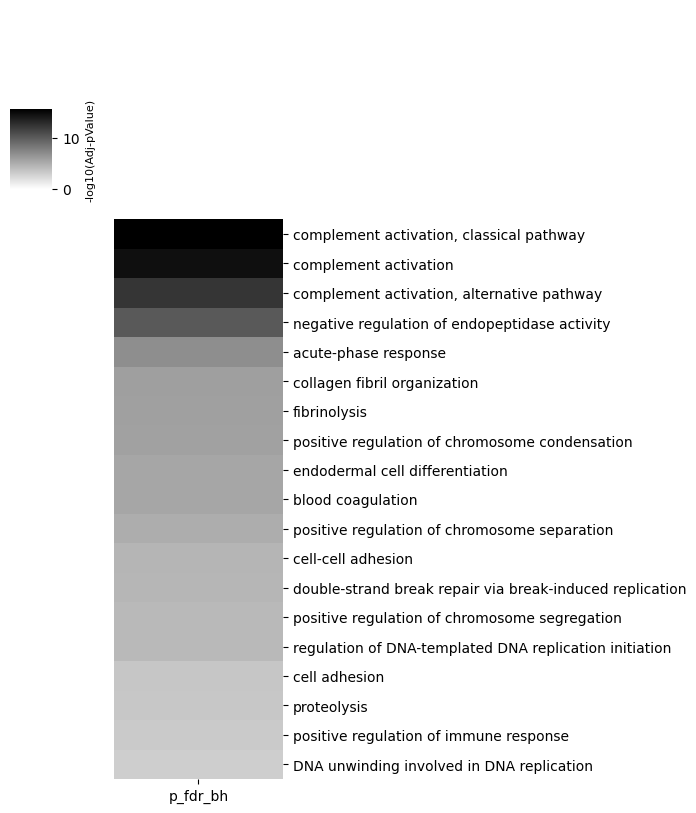

In [ ]:
cg = sns.clustermap(-np.log10(df_goea_results[(df_goea_results.Category== 'BP') & (df_goea_results['p_fdr_bh'] < 0.001)]['p_fdr_bh']), yticklabels=df_goea_results[(df_goea_results.Category== 'BP')& (df_goea_results['p_fdr_bh'] < 0.001) ].name,
              linewidths=.0, cmap="binary",figsize=(3,10),
              col_cluster = False, row_cluster = False, vmin = 0,
                   cbar_kws={'label': '-log10(Adj-pValue)',"orientation": "vertical"})
cg.fig.axes[-1].yaxis.label.set_size(8) #size legend colorbar
cg.ax_cbar.set_position([-0.01, 0.7, cg.ax_row_dendrogram.get_position().width, 0.08])

# Approach 2: **Gene set enrichment analysis**

In [202]:
df.sort_values('log2fc', ascending=False, inplace=True)
rnk = df[['Gene_id','log2fc']]
rnk.columns = [0,1]
rnk.reset_index(inplace=True, drop=True)
rnk[0] = rnk[0].astype(str) 

<ipython-input-202-e283fe607256>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnk[0] = rnk[0].astype(str)


In [203]:
# Define a dictionary to store the Gene Ontology (GO) terms and their associated genes
GO_dict = {}

# Loop through each gene and its associated biological processes (BP)
for gene, terms in ns2assoc['BP'].items():
    
    # Loop through each BP term associated with the gene
    for term in terms:
        
        # Add the gene to the list of genes associated with the BP term in the dictionary
        if term not in GO_dict:
            GO_dict[term] = []
        if gene not in GO_dict[term]:
            GO_dict[term].append(str(gene))

In [221]:
import gseapy as gp

# run prerank
# enrichr libraries are supported by prerank module. Just provide the name
# use 4 process to acceralate the permutation speed

# note: multiprocessing may not work on windows
pre_res = gp.prerank(rnk=rnk, gene_sets=GO_dict,
                     processes=4,min_size=5,max_size=1000,
                     permutation_num=5000, # reduce number to speed up testing
                     format='png', seed=6,
                    outdir='GSEA/') # set output directory

<ipython-input-221-3307bab2685e>:8: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(rnk=rnk, gene_sets=GO_dict,
2023-04-27 12:45:57,432 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-04-27 12:45:57,455 [WARNING] Duplicated values found in preranked stats: 1.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


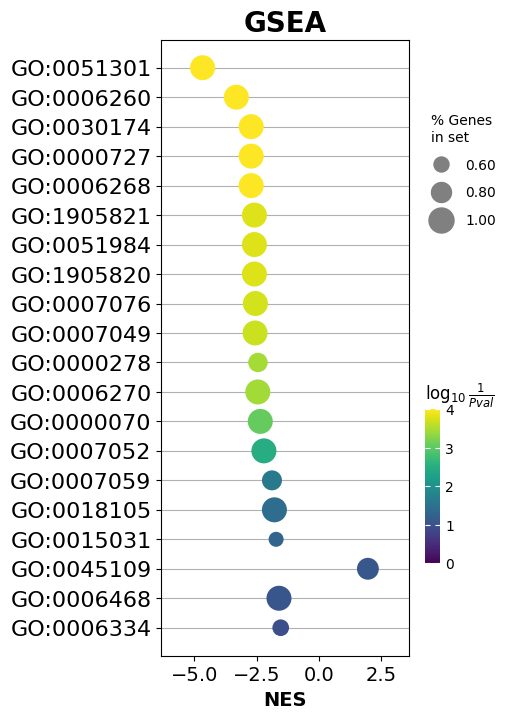

In [273]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             title='GSEA',
             cmap=plt.cm.viridis,top_term = 20,
             size=3, # adjust dot size
             figsize=(4,8), cutoff=0.25, show_ring=False)

In [269]:
dotplot?

In [268]:
len(pre_res.res2d)

117

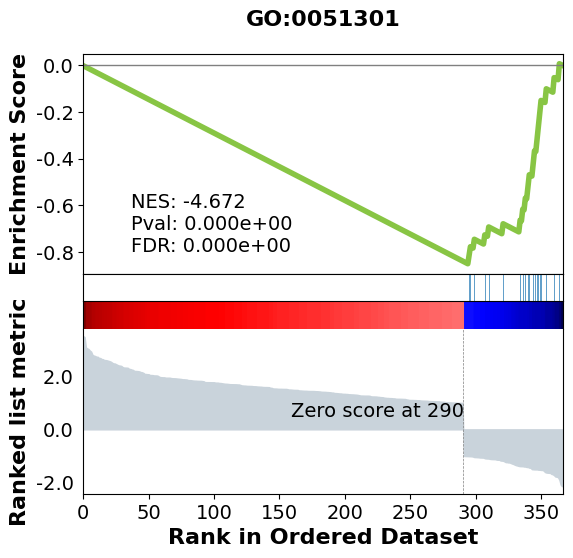

In [223]:
from gseapy import gseaplot, heatmap
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(pre_res.ranking, term='GO:0051301', **pre_res.results['GO:0051301'])

In [224]:
go_table = pre_res.res2d

In [258]:
GO_annot = {}
GO_annot = {GO: obodag[GO].name for GO in go_table.Term.unique() if GO not in GO_annot}
GO_annot_df = pd.DataFrame(GO_annot.items(), columns=['Term', 'Description'])
go_table_annotated = go_table.merge(GO_annot_df, on='Term', how='left').sort_index(axis=1)

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


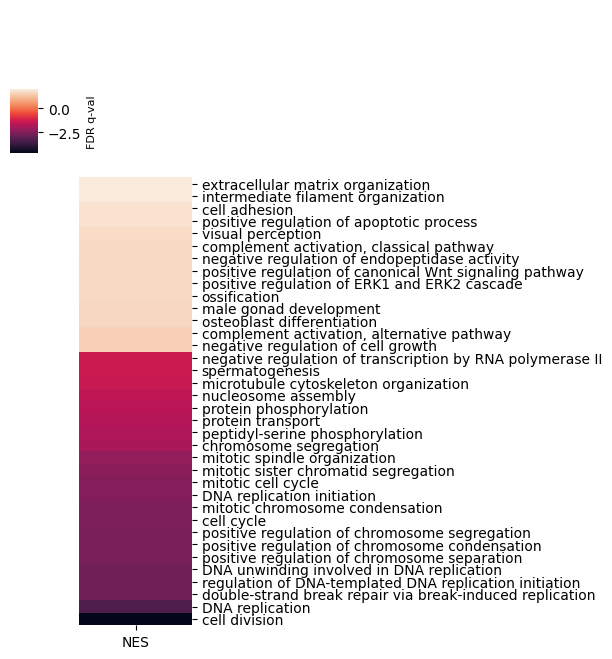

In [265]:
go_table_annotated['NES'] = pd.to_numeric(go_table_annotated['NES'], errors='coerce')
go_table_annotated.sort_values('NES', inplace=True, ascending=False)
cg = sns.clustermap(go_table_annotated.loc[go_table_annotated['FDR q-val'] < 0.25, ['NES']],
                    yticklabels=go_table_annotated.loc[go_table_annotated['FDR q-val'] < 0.25, 'Description'],
                    linewidths=0, figsize=(2, 8),
                    col_cluster=False, row_cluster=False,
                    cbar_kws={'label': 'FDR q-val', 'orientation': 'vertical'})
cg.cax.set_position([-0.01, 0.7, cg.ax_row_dendrogram.get_position().width, 0.08])
cg.cax.yaxis.label.set_size(8)